# LOAD DATA

In [34]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

from matplotlib.colors import ListedColormap
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize


In [61]:
INPUT_FILE_1 = 'ranking/v4_10354_train_scores.txt'
INPUT_FILE_2 = 'ranking/v5_6482_train_scores.txt'
WITH_QRELS = 'text_summarized_200.csv'


In [62]:

scores_1 = pd.read_csv(INPUT_FILE_1).set_index(['case_id', 'candidate_id']).rename(columns={'score': 'score_1'})
scores_2 = pd.read_csv(INPUT_FILE_2).set_index(['case_id', 'candidate_id']).rename(columns={'score': 'score_2'})
original = pd.read_csv(WITH_QRELS).set_index(['case_id', 'candidate_id'])
full_mix = scores_1.join(scores_2, how='inner').join(original, how='inner').reset_index()[['case_id', 'candidate_id', 'score_1', 'score_2', 'candidate_is_noticed']]

# Restrict to only the test cases
test_cases = pd.read_csv('test_cases_id.csv', names=['case_id'], header=None).set_index('case_id')
test_mix = full_mix.set_index('case_id').join(test_cases, how='inner').reset_index()
train_mix = full_mix[~full_mix['case_id'].isin(test_cases.reset_index()['case_id'])].reset_index()

number_cases = len(test_mix['case_id'].unique())
number_candidates= 200

print('mix: {}'.format(test_mix.shape))
print('Number of cases: {}'.format(number_cases))

nb_rels = {}
for case_id, rel in test_mix[test_mix['candidate_is_noticed'] == True].groupby(by='case_id').count()['candidate_id'].iteritems():
    nb_rels[case_id] = rel
print('Average number of rels per case: {:0.2f}'.format(np.mean([v for _,v in nb_rels.items()])))

mix: (14400, 5)
Number of cases: 72
Average number of rels per case: 4.21


# VIZ

## For the test data, the distribution of scores with regards to the true class

### MODEL 1

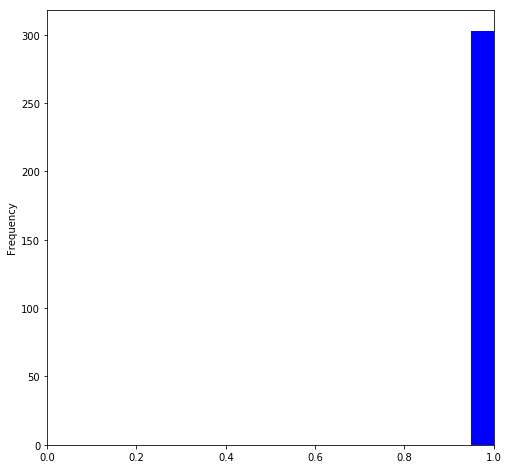

In [63]:
_ = test_mix[test_mix['candidate_is_noticed'] == True]['score_1'].plot.hist(bins=[i*0.05 for i in range(0, 21)], xlim=(0,1), color='blue',  figsize=(8,8))

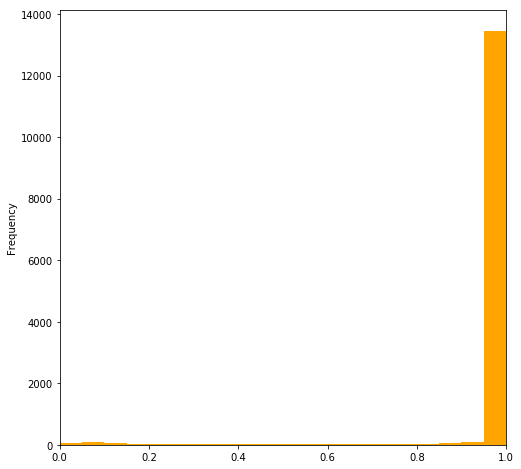

In [64]:
_ = test_mix[test_mix['candidate_is_noticed'] == False]['score_1'].plot.hist(bins=[i*0.05 for i in range(0, 21)], xlim=(0,1), color='orange',  figsize=(8,8))

### MODEL 2

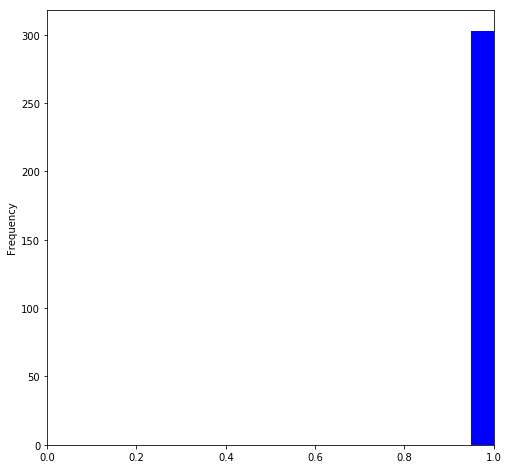

In [65]:
_ = test_mix[test_mix['candidate_is_noticed'] == True]['score_2'].plot.hist(bins=[i*0.05 for i in range(0, 21)], xlim=(0,1), color='blue',  figsize=(8,8))

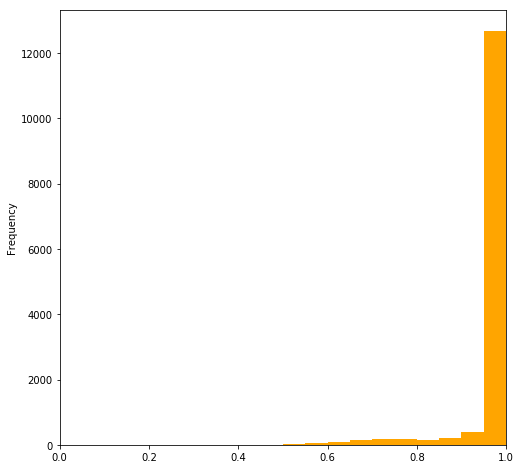

In [66]:
_ = test_mix[test_mix['candidate_is_noticed'] == False]['score_2'].plot.hist(bins=[i*0.05 for i in range(0, 21)], xlim=(0,1), color='orange',  figsize=(8,8))

### Scatter

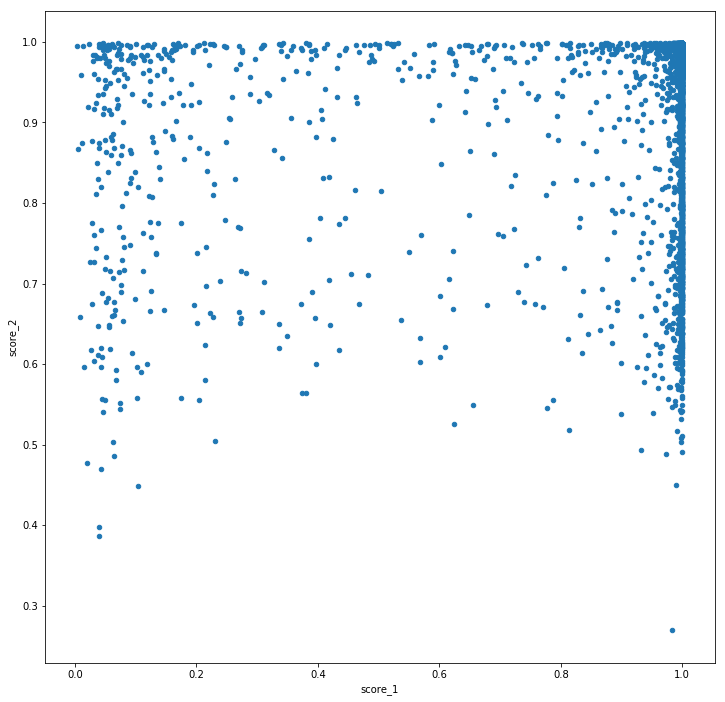

In [70]:
_ = test_mix[test_mix['candidate_is_noticed'] == False].plot.scatter(x='score_1', y='score_2', figsize=(12,12)) #, c=test_mix['candidate_is_noticed'], colormap=ListedColormap(['gray', 'orange']))

### Trying to combine both scores

In [58]:
test_mix['new_score'] = test_mix[['score_1', 'score_2']].apply(lambda x: np.log(x['score_1']), axis=1)

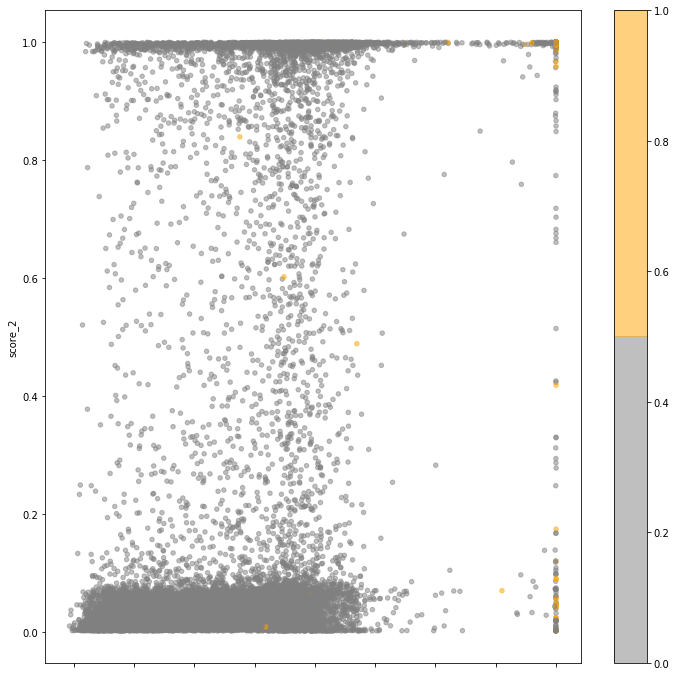

In [59]:
_ = test_mix.plot.scatter(x='new_score', y='score_2', c=test_mix['candidate_is_noticed'], figsize=(12,12), colormap=ListedColormap(['gray', 'orange']), alpha=0.5)

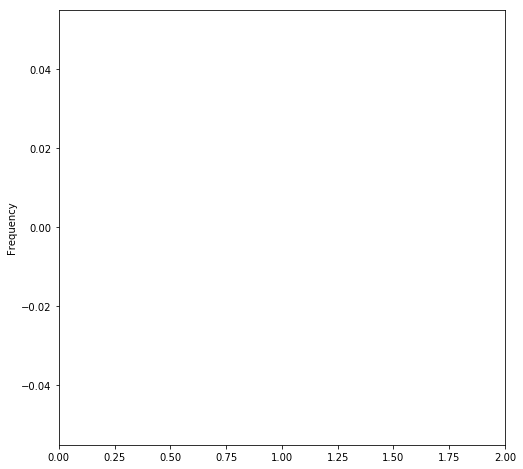

In [60]:
_ = test_mix[test_mix['candidate_is_noticed'] == False]['new_score'].plot.hist(bins=[i*0.05 for i in range(0, 41)], xlim=(0,2), color='orange',  figsize=(8,8))

# CUTTING BY SCORE

In [ ]:

cuts = []
for cut in np.arange(0.0, 1.0, 0.0001):
    results = test_mix[test_mix['score'] > cut]

    # If empty dataframe (ie : there is no candidate with a higher score than the cut)
    if len(results) == 0:
        avg_r = 0
        avg_p = 0
        avg_f1 = 0
    else:
        nb_found = {}
        nb_returned = {}

        for case_id, found in results[results['candidate_is_noticed'] == True].groupby(by='case_id').count()['candidate_id'].iteritems():
            nb_found[case_id] = found
        for case_id, returned in results.groupby(by='case_id').count()['candidate_id'].iteritems():
            nb_returned[case_id] = returned

        recall = {}
        precision = {}
        f1 = {}

        for case_id, rels in nb_rels.items():
            found = nb_found[case_id] if case_id in nb_found else 0
            returned = nb_returned[case_id] if case_id in nb_returned else 0
            r = found / rels
            p = found / returned if returned > 0 else 0
            recall[case_id] = r
            precision[case_id] = p
            f1[case_id] = (2 * p * r) / (p + r) if (p + r) > 0 else 0

        # MACRO Average
        #avg_r = sum([v for _,v in recall.items()]) / len(recall)
        #avg_p = sum([v for _,v in precision.items()]) / len(precision)
        #avg_f1 = sum([v for _,v in f1.items()]) / len(f1)

        # MICRO Average
        avg_r = sum([v for _,v in nb_found.items()]) / sum([v for _,v in nb_rels.items()])
        avg_p = sum([v for _,v in nb_found.items()]) / sum([v for _,v in nb_returned.items()])
        avg_f1 = (2 * avg_r * avg_p) / (avg_r + avg_p)

    #print('cut={:0.2f} r={:0.4f} p={:0.4f} f2={:0.4f}'.format(cut, avg_r, avg_p, avg_f1))
    cuts.append([cut, avg_r, avg_p, avg_f1])

cuts_df = pd.DataFrame(cuts, columns=['cut', 'r', 'p', 'f1'])
for metric in ['r', 'p', 'f1']:
    print('Best cut for {}: \n{}\n'.format(metric, cuts_df.sort_values(metric, ascending=False)[['cut', metric]][:1]))

# Best at F1
best_f1 = cuts_df.sort_values('f1', ascending=False)[['cut', metric]][:1]['cut'].values[0]
print('Values at best cut: R={:0.2f} P={:0.2f}'.format(cuts_df[cuts_df['cut'] == best_f1]['r'].values[0], 
                                                       cuts_df[cuts_df['cut'] == best_f1]['p'].values[0]))

In [ ]:
_ = cuts_df.plot(x='cut', y=['r', 'p', 'f1'], subplots=True, sharex=True, sharey=True, layout=(3,1), figsize=(10,30))

In [ ]:
_ = cuts_df[cuts_df['cut'] > 0.99].plot(x='cut', y=['r', 'p', 'f1'], subplots=True, sharex=True, sharey=True, layout=(3,1), figsize=(10,30))

## ROC CURVE

In [ ]:
# Compute ROC curve and ROC area for each class
y_test = np.expand_dims(test_mix['candidate_is_noticed'].values, axis=1)
y_score = np.expand_dims(test_mix['score'].values, axis=1)

print('y_test: {}'.format(y_test.shape))
print('y_score: {}'.format(y_score.shape))
    
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(1):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [ ]:
plt.figure(figsize=(12,12))
lw = 2
plt.plot(fpr[0], tpr[0], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[0])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

# CUTTING BY RANK

In [ ]:
cuts = []
ranked = test_mix.sort_values(by=['case_id', 'score'], ascending=[True, False])
ranked['rank'] = list(np.arange(1, number_candidates+1, 1)) * number_cases

for cut in np.arange(1, number_candidates+1, 1):
    results = ranked[ranked['rank'] <= cut]

    nb_found = {}
    nb_returned = {}

    for case_id, found in results[results['candidate_is_noticed'] == True].groupby(by='case_id').count()['candidate_id'].iteritems():
        nb_found[case_id] = found
    for case_id, returned in results.groupby(by='case_id').count()['candidate_id'].iteritems():
        nb_returned[case_id] = returned

    recall = {}
    precision = {}
    f1 = {}

    for case_id, rels in nb_rels.items():
        found = nb_found[case_id] if case_id in nb_found else 0
        returned = nb_returned[case_id] if case_id in nb_returned else 0
        r = found / rels
        p = found / returned if returned > 0 else 0
        recall[case_id] = r
        precision[case_id] = p
        f1[case_id] = (2 * p * r) / (p + r) if (p + r) > 0 else 0

        # MACRO Average
        #avg_r = sum([v for _,v in recall.items()]) / len(recall)
        #avg_p = sum([v for _,v in precision.items()]) / len(precision)
        #avg_f1 = sum([v for _,v in f1.items()]) / len(f1)

        # MICRO Average
        avg_r = sum([v for _,v in nb_found.items()]) / sum([v for _,v in nb_rels.items()])
        avg_p = sum([v for _,v in nb_found.items()]) / sum([v for _,v in nb_returned.items()])
        avg_f1 = (2 * avg_r * avg_p) / (avg_r + avg_p)

    #print('cut={:0.2f} r={:0.4f} p={:0.4f} f2={:0.4f}'.format(cut, avg_r, avg_p, avg_f1))
    cuts.append([cut, avg_r, avg_p, avg_f1])

rank_cuts_df = pd.DataFrame(cuts, columns=['cut', 'r', 'p', 'f1'])
for metric in ['r', 'p', 'f1']:
    print('Best cut for {}: \n{}\n'.format(metric, rank_cuts_df.sort_values(metric, ascending=False)[['cut', metric]][:1]))

# Best at F1
best_f1 = rank_cuts_df.sort_values('f1', ascending=False)[['cut', metric]][:1]['cut'].values[0]
print('Values at best cut: R={:0.2f} P={:0.2f}'.format(rank_cuts_df[rank_cuts_df['cut'] == best_f1]['r'].values[0], 
                                                       rank_cuts_df[rank_cuts_df['cut'] == best_f1]['p'].values[0]))

In [ ]:
_ = rank_cuts_df.plot(x='cut', y=['r', 'p', 'f1'], subplots=True, sharex=True, sharey=True, layout=(3,1), figsize=(10,30))